In [1]:
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

model = load_model("HCRmodel.h5")

Using TensorFlow backend.


In [2]:
def FindLargestContour(ctrs):
    max = 0.0
    for ctr in ctrs:
        area = cv2.contourArea(ctr)
        if max < area:
            max = area
    return float(max)

def RemoveSmallContours(ctrs, image):
    mask = np.zeros(image.shape[:2], dtype=image.dtype)
    maxArea = FindLargestContour(ctrs)
    print('Max = ' + str(maxArea))
    for ctr in ctrs:
        if cv2.contourArea(ctr) > 0.3 * maxArea:
            x, y, w, h = cv2.boundingRect(ctr)
            cv2.drawContours(mask, [ctr], 0, (255), -1)
    result = cv2.bitwise_and(image, image, mask= mask)
    ctrs, _ = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return ctrs

In [3]:
def PredictString(image): 
    classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    image = cv2.imread(image)
    height, width, depth = image.shape

    image = cv2.resize(image, dsize=(width*5,height*4), interpolation=cv2.INTER_CUBIC)
    #grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #binary
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
    #dilation
    kernel = np.ones((5,5), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)
    #adding GaussianBlur
    gsblur=cv2.GaussianBlur(img_dilation,(5,5),0)
    #find contours
    ctrs, _ = cv2.findContours(gsblur.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    m = list()
    print(type(ctrs))
    #sort contours
    ctrs = RemoveSmallContours(ctrs, gsblur.copy())
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    pchl = list()
    dp = image.copy()
    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(dp,(x-15,y-15),( x + w + 15, y + h + 15 ),(90,0,255),9)    
    plt.imshow(dp)
    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = image[y-15:y+h+15, x-15:x+w+15]
        roi = cv2.resize(roi, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)

        roi = np.array(roi)
        t = np.copy(roi)
        t = t / 255.0
        t = 1-t
        t = t.reshape(28, 28, 1)
        t = np.expand_dims(t, axis=0)
        m.append(roi)
        pred = model.predict_classes(t)
        pchl.append(pred)
        print('Prediction = ', classes[pchl[i][0]])

    pcw = list()
    interp = 'bilinear'
    fig, axs = plt.subplots(nrows=len(sorted_ctrs), sharex=True, figsize=(1,len(sorted_ctrs)))
    for i in range(len(pchl)):
        #print (pchl[i][0])
        pcw.append(classes[pchl[i][0]])
        axs[i].set_title('-------> predicted letter: '+classes[pchl[i][0]], x=2.5,y=0.24)
        axs[i].imshow(m[i], interpolation=interp)

    plt.show()


    predstring = ''.join(pcw)
    print('Predicted String: '+predstring)
    return predstring

<class 'list'>
Max = 76691.5
Prediction =  n
Prediction =  e
Prediction =  V
Prediction =  e
Prediction =  r


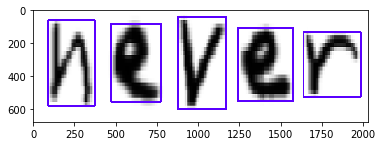

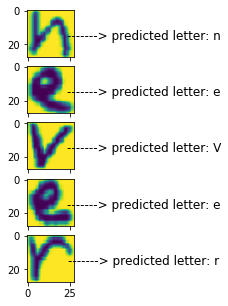

Predicted String: neVer


'neVer'

In [4]:
PredictString('sample.png')